In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [3]:
class FruitNet:
    def __init__(self, model_config_path):
        self.model = tf.keras.models.load_model(model_config_path)

    def predict(self, img_file):
        labels = ['fresh', 'rotten']

        img_tensor = tf.image.decode_image(img_file)
        img_resized = tf.image.resize(img_tensor, [224, 224])
        img_final = tf.expand_dims(img_resized, 0)

        y_probs = self.model.predict(img_final[:,:,:,:3])
        y_label = y_probs.argmax(axis=-1)

        label = labels[y_label[0]]
        percentage = format(y_probs.max() * 100, '.2f')

        return label, percentage

In [4]:
train_path = '/content/drive/MyDrive/DataSet/train'
valid_path = '/content/drive/MyDrive/DataSet/val'
test_path = '/content/drive/MyDrive/DataSet/test'
img_size =  (224,224,3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 30

In [5]:
datagen = ImageDataGenerator(rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             channel_shift_range = 10,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

In [6]:
train_dataset = datagen.flow_from_directory(directory = train_path,
                                                  color_mode = "rgb",
                                                  target_size = (224,224),
                                                  interpolation = 'bicubic',
                                                  class_mode = "categorical",
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE)

validation_dataset  = datagen.flow_from_directory(directory = valid_path,
                                            color_mode = "rgb",
                                            target_size = (224,224),
                                            interpolation = 'bicubic',
                                            class_mode = "categorical",
                                            shuffle = False,
                                            batch_size = BATCH_SIZE)
test_dataset  = datagen.flow_from_directory(directory = test_path,
                                           color_mode = "rgb",
                                           target_size = (224,224),
                                           interpolation = 'bicubic',
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = BATCH_SIZE)

Found 1410 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [7]:
LABELS = ['fresh', 'rotten']

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = False

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 7, 7, 1280)


In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 2)


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [18]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 3s 367ms/step - loss: 0.8378 - accuracy: 0.5000


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.50


In [20]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/30
177/177 [==============================] - 188s 1s/step - loss: 0.1527 - accuracy: 0.9426 - val_loss: 0.0933 - val_accuracy: 0.9000
Epoch 2/30
177/177 [==============================] - 77s 437ms/step - loss: 0.0286 - accuracy: 0.9957 - val_loss: 0.2738 - val_accuracy: 0.9000
Epoch 3/30
177/177 [==============================] - 73s 410ms/step - loss: 0.0216 - accuracy: 0.9950 - val_loss: 0.0616 - val_accuracy: 1.0000
Epoch 4/30
177/177 [==============================] - 72s 404ms/step - loss: 0.0134 - accuracy: 0.9986 - val_loss: 0.0453 - val_accuracy: 1.0000
Epoch 5/30
177/177 [==============================] - 76s 430ms/step - loss: 0.0122 - accuracy: 0.9979 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 6/30
177/177 [==============================] - 71s 398ms/step - loss: 0.0101 - accuracy: 0.9986 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 7/30
177/177 [==============================] - 71s 400ms/step - loss: 0.0130 - accuracy: 0.9979 - val_loss: 0.0666 - val_accu

In [21]:
score = model.evaluate(test_dataset)
print("Accuracy: ",score[1])

75/75 [==============================] - 133s 2s/step - loss: 0.2981 - accuracy: 0.9033
Accuracy:  0.903333306312561


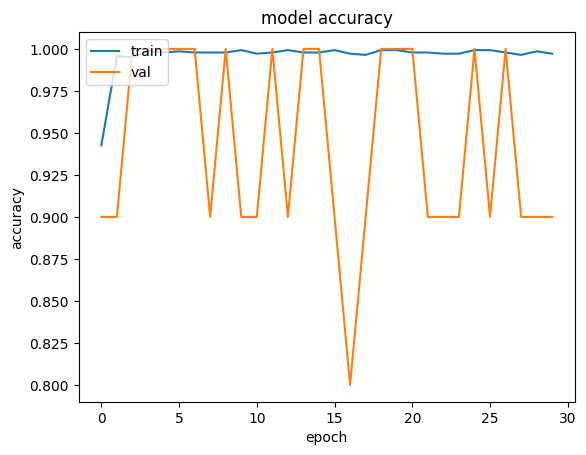

In [22]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

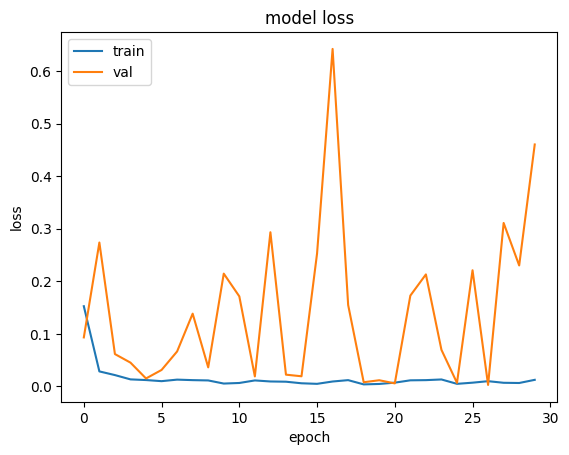

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import classification_report
test_labels = test_dataset.classes
predictions = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred, target_names = test_dataset.class_indices))

75/75 [==============================] - 31s 399ms/step
              precision    recall  f1-score   support

       Curuk       0.83      1.00      0.91       300
        Taze       1.00      0.80      0.89       300

    accuracy                           0.90       600
   macro avg       0.92      0.90      0.90       600
weighted avg       0.92      0.90      0.90       600



In [27]:
from PIL import Image

img_path='/content/drive/MyDrive/DataSet/rotten.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction=model.predict(img_preprocessed)

1/1 [==============================] - 2s 2s/step


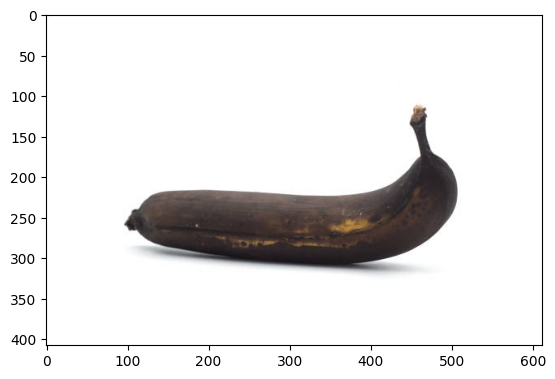

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/drive/MyDrive/DataSet/rotten.jpg")
plt.imshow(img)
plt.show()

In [30]:
prediction

array([[9.9974388e-01, 2.5608038e-04]], dtype=float32)